In [4]:
import glob

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [5]:
tsv_files = glob.glob("data/*.tsv")
dfs = []

for file in tsv_files:
    df = pd.read_csv(file, sep="\t")
    df["language"] = file.split("-")[-1].replace(".tsv", "")
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)

## Data Overview

In [6]:
data.head()
data.info()
data.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3400 entries, 0 to 3399
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3400 non-null   object
 1   word1     3400 non-null   object
 2   word2     3400 non-null   object
 3   headline  3400 non-null   object
 4   language  3400 non-null   object
dtypes: object(5)
memory usage: 132.9+ KB


,id,word1,word2,headline,language
count,3400,3400,3400,3400,3400
unique,3400,65,120,3099,3
top,zh_1000,-,-,-,en
freq,1,3100,3100,300,1200


## Change "-" placeholder with NaN

In [7]:
data = data.replace("-", np.nan)

print("Missing values per column:")
data.isna().sum()

Missing values per column:


id             0
word1       3100
word2       3100
headline     300
language       0
dtype: int64

## Types of constraints

In [8]:
def determine_constraint(row):
    if pd.isna(row["word1"]) and pd.isna(row["word2"]) and not pd.isna(row["headline"]):
        return "headline"
    elif pd.isna(row["headline"]) and not pd.isna(row["word1"]) and not pd.isna(row["word2"]):
        return "word_comb"
    else:
        return "error"

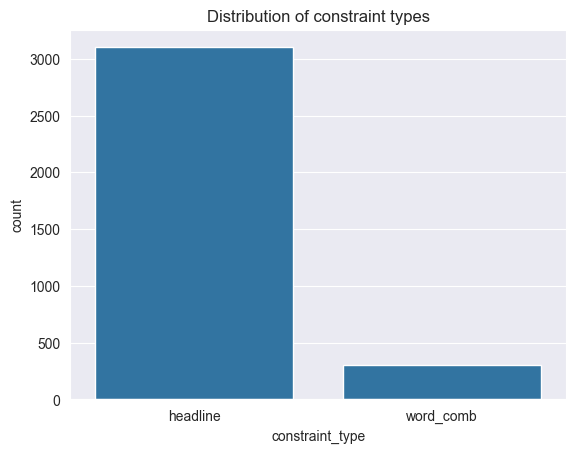

In [9]:
data["constraint_type"] = data.apply(determine_constraint, axis=1)
data["constraint_type"].value_counts()
sns.countplot(x="constraint_type", data=data)
plt.title("Distribution of constraint types")
plt.show()

## Analysis by constraint type

C:\Users\enbysenpai\AppData\Local\Temp\ipykernel_19764\4165503888.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  headline_data["length"] = headline_data["headline"].str.len()


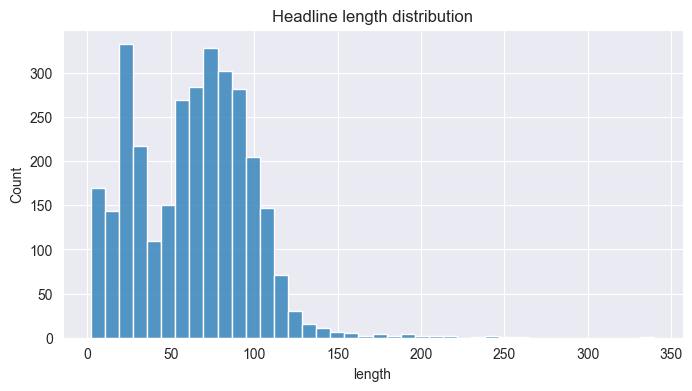

In [10]:
headline_data = data[data["constraint_type"] == "headline"]
headline_data["length"] = headline_data["headline"].str.len()
headline_data["length"].describe()
plt.figure(figsize=(8, 4))
sns.histplot(headline_data["length"], bins=40)
plt.title("Headline length distribution")
plt.show()

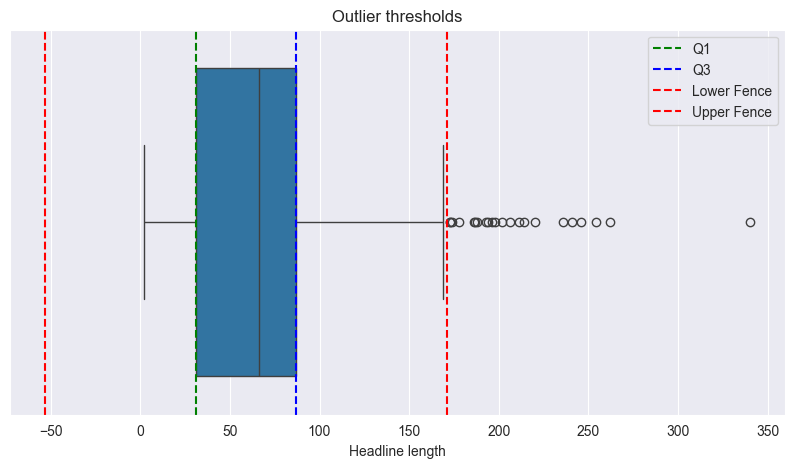

Outlier headlines: 22


,id,word1,word2,headline,language,constraint_type,length
224,en_0225,NaN,NaN,Americans are socialising less - here’s why th...,en,headline,173
249,en_0250,NaN,NaN,Optus customers left angry after more failed t...,en,headline,198
258,en_0259,NaN,NaN,Why Salah has become a 'little problem' for Li...,en,headline,188
260,en_0261,NaN,NaN,"Cyberattacks Upset British Life, Disrupting Ca...",en,headline,262
328,en_0329,NaN,NaN,Space weather satellites blast off to collect ...,en,headline,236


In [11]:
# Remove outliers (based on headline length)
q1 = headline_data["length"].quantile(0.25)
q3 = headline_data["length"].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

plt.figure(figsize=(10, 5))

sns.boxplot(x=headline_data["length"])
plt.axvline(q1, color="green", linestyle="--", label="Q1")
plt.axvline(q3, color="blue", linestyle="--", label="Q3")
plt.axvline(lower, color="red", linestyle="--", label="Lower Fence")
plt.axvline(upper, color="red", linestyle="--", label="Upper Fence")

plt.title("Outlier thresholds")
plt.xlabel("Headline length")
plt.legend()
plt.show()

outliers = headline_data[(headline_data["length"] < lower) |
                         (headline_data["length"] > upper)]

print("Outlier headlines:", len(outliers))
outliers.head()

In [12]:
word_data = data[data["constraint_type"] == "word_comb"]
word_data["pair"] = word_data["word1"] + " + " + word_data["word2"]

print("Unique word pairs:", word_data["pair"].nunique())
word_data["pair"].value_counts().head()

Unique word pairs: 300


C:\Users\enbysenpai\AppData\Local\Temp\ipykernel_19764\3873170199.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  word_data["pair"] = word_data["word1"] + " + " + word_data["word2"]


pair
移动 + 树              1
spray + chair       1
hammer + banana     1
move + fridge       1
hammer + pumpkin    1
Name: count, dtype: int64

## Language distribution

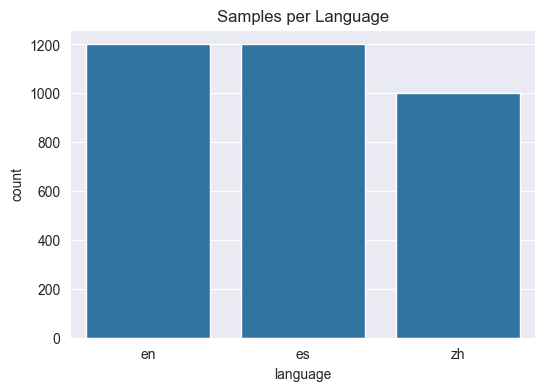

In [13]:
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x="language")
plt.title("Samples per Language")
plt.show()

## Duplicates

In [14]:
print("Duplicate headlines:", headline_data["headline"].duplicated().sum())
print("Duplicate word pairs:", word_data["pair"].duplicated().sum())
headline_data = headline_data.drop_duplicates(subset=["headline"])

Duplicate headlines: 2
Duplicate word pairs: 0
